<a href="https://colab.research.google.com/github/lpanigrahi/LORA-PEFT/blob/main/GPT_2_Fine_Tuning_w_Hugging_Face_%26_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch.
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
!pip install transformers

In [2]:
!pip install datasets -U
!pip install peft -U

In [3]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random
import datasets
from datasets import load_dataset

import matplotlib.pyplot as plt
# % matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel, GPT2Model
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
!nvidia-smi

Sat Sep 23 05:02:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
WORKING_DIR = '/content/drive/MyDrive/workbook/GPT2-PEFT'

In [7]:
%cd {WORKING_DIR}

/content/drive/MyDrive/workbook/GPT2-PEFT


In [8]:
dataset_name = "iamtarun/python_code_instructions_18k_alpaca"
dataset_split = "train"
# Load dataset from the hub
dataset = load_dataset(dataset_name, split=dataset_split)
# Show dataset size
print(f"dataset size: {len(dataset)}")

dataset size: 18612


In [9]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

## Tokenize the instruction dataset

In [10]:
def tokenize_function(examples):
    return tokenizer(examples['prompt'], padding="max_length", truncation=True)

In [11]:
tokenizer.pad_token = tokenizer.eos_token

In [12]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [13]:
tokenized_dataset

Dataset({
    features: ['instruction', 'input', 'output', 'prompt', 'input_ids', 'attention_mask'],
    num_rows: 18612
})

In [14]:
sample_dataset = tokenized_dataset.remove_columns(['instruction', 'input', 'output', 'prompt'])

In [15]:
tokenized_dataset['prompt'][1000]

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDesign a function in Python to find the maximum pair sum from the list input.\n\n### Input:\ninput_list = [20, 11, 33, 67, 89 ,34]\n\n### Output:\ndef maxPairSum(input_list):\n\n    #assume the first and second elements are the max pair\n    max_pair_sum = input_list[0] + input_list[1]\n\n    # Keep track of the max pair\n    pair_index_one = 0\n    pair_index_two = 1\n\n    # iterate through the entire list\n    for index_one in range(0, len(input_list)):\n        for index_two in range(index_one + 1, len(input_list)):\n\n            # if the current pair sum is greater than the max pair sum\n            # update the max pair sum and the pair indices\n            if input_list[index_one] + input_list[index_two] > max_pair_sum:\n                max_pair_sum = input_list[index_one] + input_list[index_two]\n                pair_index_one = index_one\n           

In [16]:
tokenizer.decode(tokenized_dataset['input_ids'][1000])

'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nDesign a function in Python to find the maximum pair sum from the list input.\n\n### Input:\ninput_list = [20, 11, 33, 67, 89,34]\n\n### Output:\ndef maxPairSum(input_list):\n\n    #assume the first and second elements are the max pair\n    max_pair_sum = input_list[0] + input_list[1]\n\n    # Keep track of the max pair\n    pair_index_one = 0\n    pair_index_two = 1\n\n    # iterate through the entire list\n    for index_one in range(0, len(input_list)):\n        for index_two in range(index_one + 1, len(input_list)):\n\n            # if the current pair sum is greater than the max pair sum\n            # update the max pair sum and the pair indices\n            if input_list[index_one] + input_list[index_two] > max_pair_sum:\n                max_pair_sum = input_list[index_one] + input_list[index_two]\n                pair_index_one = index_one\n            

In [17]:
len(sample_dataset)

18612

# PyTorch Datasets & Dataloaders


In [18]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, gpt2_type="gpt2"):

    self.input_ids = [torch.tensor(x) for x in txt_list['input_ids']]
    self.attn_masks = [torch.tensor(x) for x in txt_list['attention_mask']]

    # for i in range(len(txt_list)):

    #   self.input_ids.append(torch.tensor(txt_list['input_ids'][0]))
    #   self.attn_masks.append(torch.tensor(txt_list['attention_mask'][0]))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [19]:
split_dataset = sample_dataset.train_test_split(test_size=0.1, shuffle=True, seed=123)

In [20]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 16750
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 1862
    })
})

In [21]:
train_dataset = GPT2Dataset(split_dataset['train'])

In [22]:
test_dataset = GPT2Dataset(split_dataset['test'])

In [26]:
batch_size = 4

In [27]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [28]:
next(iter(train_dataloader))

[tensor([[21106,   318,   281,  ..., 50256, 50256, 50256],
         [21106,   318,   281,  ..., 50256, 50256, 50256],
         [21106,   318,   281,  ..., 50256, 50256, 50256],
         [21106,   318,   281,  ..., 50256, 50256, 50256]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])]

GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

# Finetune GPT2 Language Model

In [29]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2-large', output_hidden_states=False)

# instantiate the model
original_model = GPT2LMHeadModel.from_pretrained("gpt2-large", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
# model.resize_token_embeddings(len(tokenizer))


# # Tell pytorch to run this model on the GPU.
# device = torch.device("cpu")
# model.cpu()

# # Set the seed value all over the place to make this reproducible.
# seed_val = 42

# random.seed(seed_val)
# np.random.seed(seed_val)
# torch.manual_seed(seed_val)
# torch.cuda.manual_seed_all(seed_val)

### Post-processing on the model

In [30]:
model = original_model
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [31]:
# some parameters I cooked up that work reasonably well

epochs = 1
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 500

In [32]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [34]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

# Setup PEFT/LoRA Finetuning

In [35]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2-large', output_hidden_states=False)

# instantiate the model
original_model = GPT2LMHeadModel.from_pretrained("gpt2-large", config=configuration)

In [27]:
# original_model = GPT2LMHeadModel.from_pretrained('gpt2-large', torch_dtype=torch.bfloat16)

In [ ]:
model = original_model
for param in model.parameters():
  param.requires_grad = False  # freeze the model - train adapters later
  if param.ndim == 1:
    # cast the small parameters (e.g. layernorm) to fp32 for stability
    param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations
model.enable_input_require_grads()

class CastOutputToFloat(nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
model.lm_head = CastOutputToFloat(model.lm_head)

In [29]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
        r=32,
        lora_alpha=32,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        # tune the embedding layer and prediction head
        modules_to_save=["wte", "lm_head"]
        # modules_to_save=["wte"]
)

In [30]:
peft_model = get_peft_model(model,
                        lora_config)

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora.py:475: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [31]:
print(print_number_of_trainable_model_parameters(model))

trainable model parameters: 5898240
all model parameters: 779928320
percentage of trainable model parameters: 0.76%


In [32]:
# some parameters I cooked up that work reasonably well

epochs = 1
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 500

In [33]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [34]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [35]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [36]:
device='cuda'
# model = peft_model
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        # batch.to(device)

        model.zero_grad()

        outputs = model(  input_ids = b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )
        # outputs = model(**batch)


        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...



======== Epoch 1 / 1 ========
Training...


KeyboardInterrupt: ignored

Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.258107,0.199251,1:40:23,0:03:33


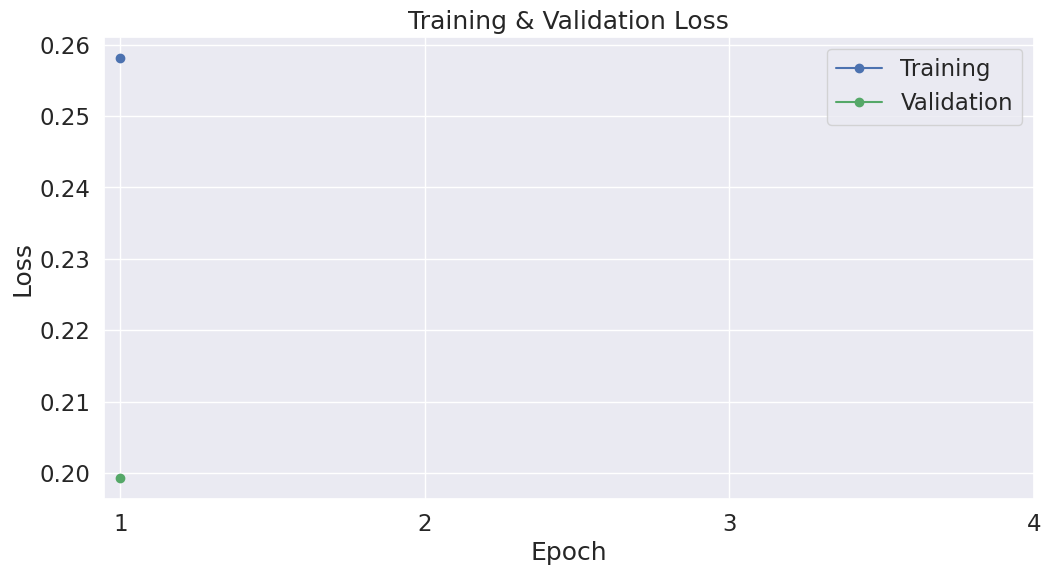

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50257, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 487565K
-rw------- 1 root root      1K Sep 21 19:51 config.json
-rw------- 1 root root      1K Sep 21 19:51 generation_config.json
-rw------- 1 root root    446K Sep 21 19:51 merges.txt
-rw------- 1 root root 486140K Sep 21 19:51 pytorch_model.bin
-rw------- 1 root root      1K Sep 21 19:51 special_tokens_map.json
-rw------- 1 root root      1K Sep 21 19:51 tokenizer_config.json
-rw------- 1 root root    976K Sep 21 19:51 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw------- 1 root root 475M Sep 21 19:51 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
# !cp -r ./model_save/ $data_dir
output_dir = './model_save'
device = 'cpu'
# # Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# Generate Text

In [ ]:
text = 'Write a program to convert farenhite to celcious'
input = ''
prompt = f"""Below is an instruction that describes a task. Write a response that appropriately completes the request.\

### Instruction:\
{text}\

### Input:\
{input}\
### Output:"""

In [ ]:
text = 'Write a program to calculate farenhite to celcious'
print(prompt)

Below is an instruction that describes a task. Write a response that appropriately completes the request.
### Instruction:Write a program to calculate farenhite to celcious
### Input:### Output:


In [ ]:
model.eval()

# prompt = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

# ### Instruction:
# {text}
# ### Input:
# {}
# ### Output:"""


generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 1000,
                                top_p=0.95,
                                num_return_sequences=1
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[21106,   318,   281, 12064,   326,  8477,   257,  4876,    13, 19430,
           257,  2882,   326, 20431, 32543,   262,  2581,    13,   198, 21017,
         46486,    25, 16594,   257,  1430,   284, 10385,   277,  5757,    71,
           578,   284, 18725,  4680,   198, 21017, 23412,    25, 21017, 25235,
            25]])
0: Below is an instruction that describes a task. Write a response that appropriately completes the request.
### Instruction:Write a program to convert farenhite to celcious
### Input:### Output:
def farenhite_to_celcious(f, lhs):
  celsius = 0
  longitude = 0
  while (lhs!= 0 and lhs!= 0):
    temp = temp + lhs
    s = lhs - lhs

    if (lhs > s):
       celery_celcious = lhs

    else:
        celery_celcious = f

        longitude += celery_celcious + longitude
    else:
        celery_celcious = lhs - lhs

    return celery_celcious, celery_celcious




These aren't bad at all!
